# Targeted Analysis (2k Samples)

In [7]:
import warnings
warnings.filterwarnings('ignore')

import pdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from api.text_operations import (
    clean_data,
    encode_text
)
from api.text_clustering import create_clusters

# SKLearn imports
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA, LatentDirichletAllocation

[nltk_data] Downloading package stopwords to /home/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Load Data and Cluster

In [9]:
data = pd.read_csv('sample_2000_M5_socialv3.csv')

In [3]:
# Clean text data
clean_df = clean_data(data)

# Get text encodings
encoding_dict = encode_text(clean_df)

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [4]:
# Assemble text encodings
X = np.array([encoding_dict[r['EIN']] for _, r in clean_df.iterrows()])
print(X.shape)

(2000, 512)


In [5]:
# Dimensionality reduction (clustering)
pca_dimr = PCA(n_components=200)
X_dimr = pca_dimr.fit_transform(X)
expvar_1 = sum(pca_dimr.explained_variance_ratio_)

# Dimensionality reduction (t-SNE)
pca_tsne = PCA(n_components=70).fit(X)
X_tsne = pca_tsne.fit_transform(X)
expvar_2 = sum(pca_tsne.explained_variance_ratio_)

print('Explained variance (clustering): %.4f'%expvar_1)
print('Explained variance (t-SNE): %.4f'%expvar_2)

Explained variance (clustering): 0.9516
Explained variance (t-SNE): 0.8493


In [6]:
# Get cluster results
Z, gap_metrics, bc, clusters = create_clusters(X_dimr, C=100)

Scanning: 10
Scanning: 20
Scanning: 30
Scanning: 40
Scanning: 50
Scanning: 60
Scanning: 70
Scanning: 80
Scanning: 90
Scanning: 100

Cluster sizes: [35 38 42 44 47 48 51 53 54 56 59 60 64 66 67 69 71 73 74 75 76 78 79 81
 82 84 85 86 89 91 92 93 94 95 96 97 98 99]


In [7]:
# Update clean df
clean_df['cluster'] = clusters

## Interpret Results

### t-SNE Visualization

In [8]:
# Get t-SNE embedding
X_temb = TSNE(
    n_components=2, verbose=1, perplexity=40, n_iter=500
).fit_transform(X_tsne)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.005s...
[t-SNE] Computed neighbors for 2000 samples in 0.668s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.245704
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.918251
[t-SNE] KL divergence after 500 iterations: 1.524157


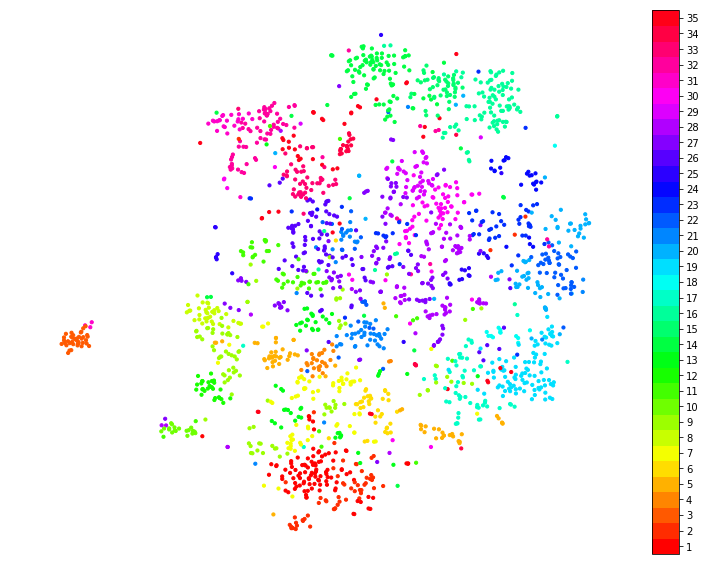

In [72]:
# Visualize t-SNE plot
vis_x = X_temb[:, 0]
vis_y = X_temb[:, 1]

plt.figure(figsize=(13, 10))
plt.axis('off')
plt.scatter(
    x=vis_x, 
    y=vis_y,
    s=10,
    c=clusters, 
    cmap=plt.cm.get_cmap('hsv', bc[0])
)
plt.colorbar(ticks=range(bc[0]+1))
plt.clim(0.5, bc[0]+0.5)
plt.show()

### LDA Verification

In [110]:
#------------------------------------------------------------------------------#
def display_topics(model, feature_names, no_top_words):
    """
    Helper function for displaying top words of a topic
    """
    for topic_idx, topic in enumerate(model.components_):
        print('\nTopic %d:'%(topic_idx+1))
        print(' '.join([
            feature_names[i] for i in topic.argsort()[:-no_top_words-1:-1]
        ]))
    
    return None


def topic_distribution(df, X_lda, n_clusters, cluster_num):
    """
    Helper function for displaying distribution of LDA topics for a single 
    cluster
    """
    # Get indexes of topic selection
    select_df = df[df['cluster']==cluster_num].copy(deep=True)
    select_idx = select_df.index.values
    
    # Aggregate probabilties
    X_prob = X_lda[select_idx]
    X_max = np.max(X_prob)
    agg_probs = np.prod(X_prob/X_max, axis=0)
    
    # Plot probabilities
    fig, ax = plt.subplots(3, 1, figsize=(10, 21))
    ax[0].bar(
        x = np.arange(n_clusters)+1,
        height = agg_probs,
        width=0.6
    )
    ax[0].set_xticks(np.arange(1, n_clusters+1, 2))
    ax[0].set_title('LDA Topic Probabilities for Cluster %d'%cluster_num)
    ax[0].set_ylabel('Agg. Probability')
    ax[0].set_xlabel('LDA Topic Numbers')
    
    # Plot argmax distribution
    argmax = np.argmax(X_prob, axis=1)+1
    argmax_idx, argmax_cnt = np.unique(argmax, return_counts=True)
    
    x_axis = np.arange(n_clusters)+1
    y_axis = np.array([
        argmax_cnt[np.where(argmax_idx==n)[0]][0]
        if n in argmax_idx else 0
        for n in x_axis
    ])
    ax[1].bar(
        x = x_axis,
        height = y_axis,
        width=0.6
    )
    ax[1].set_xticks(np.arange(1, n_clusters+1, 2))
    ax[1].set_title('LDA Topic Counts for Cluster %d'%cluster_num)
    ax[1].set_ylabel('LDA Topic Counts')
    ax[1].set_xlabel('LDA Topic Numbers')
    
    # Probability density calculations
    prob_df = pd.DataFrame(
        data = X_prob,
        index = np.arange(len(select_idx)),
        columns = np.arange(n_clusters)
    )
    prob_df.plot.kde(legend=False, ax=ax[2])
    ax[2].set_title('Probability Density Plot for Cluster %d'%cluster_num)
    plt.show()
    
    return None
#------------------------------------------------------------------------------#

In [54]:
# Count-vectorize corpus
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000)
tf = tf_vectorizer.fit_transform(clean_df['Text'].values)
tf_feature_names = tf_vectorizer.get_feature_names()

In [11]:
# Run LDA
lda = LatentDirichletAllocation(
    n_components=bc[0], 
    max_iter=5,
    random_state=0
)
X_lda = lda.fit_transform(tf)

In [75]:
# Show top words of topics
display_topics(lda, tf_feature_names, 10)


Topic 1:
youth club provide program recreational activity social sport member soccer

Topic 2:
public information access medium organization general technology issue community people

Topic 3:
organization foundation museum inc fund literacy community mission program jewish

Topic 4:
community ministry people inc resource provide child church operate program

Topic 5:
community youth hope center financial young theatre operation people program

Topic 6:
land conservation institute work environmental organization event program trust habitat

Topic 7:
animal promote organization adoption rescue education pet shelter public humane

Topic 8:
community organization association state public national resource land education energy

Topic 9:
art community music program performance cultural center artist educational year

Topic 10:
service fire volunteer kid community emergency provide organization medical new

Topic 11:
community development river improve organization program water quality pe

In [121]:
X_lda.shape

(2000, 35)

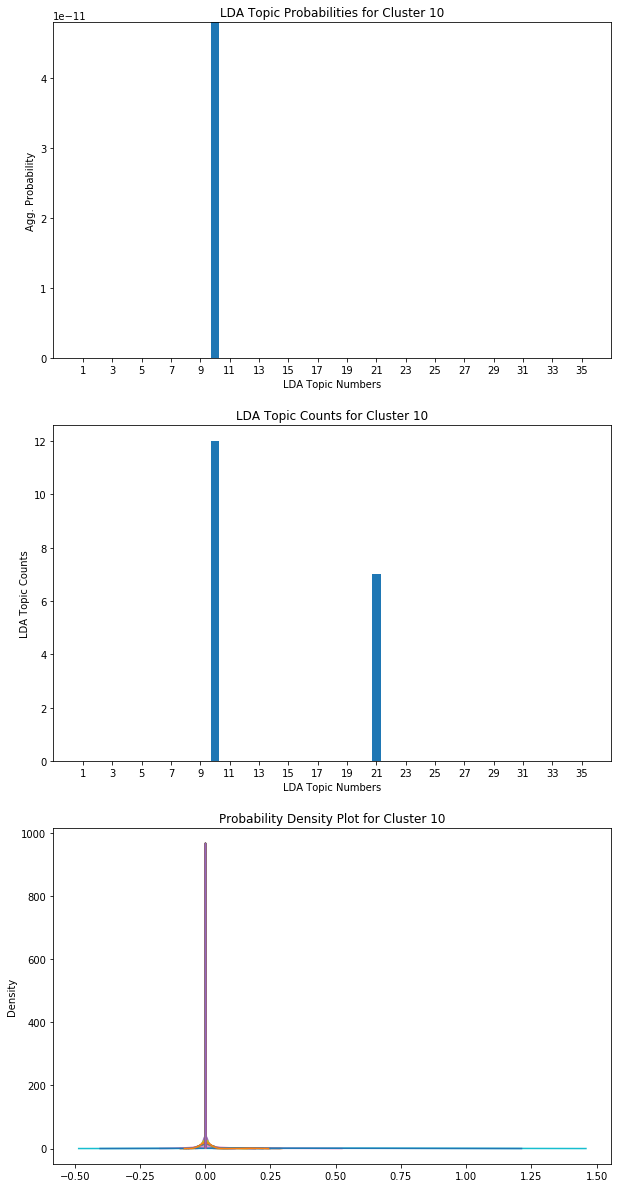

In [126]:
# Visualize topic distribution
topic_distribution(clean_df, X_lda, bc[0], 10)